# Entrenamiento del modelo

In [1]:
import pandas as pd
import numpy as np

### Leemos el DataSet de entrenamiento normalizado

In [2]:
# Para el entrenamiento solo necesitamos el Dataset train
df = pd.read_csv('../datasets/normal_train.csv')

## Variables del modelo

In [3]:
# 1. Crear la matriz y con todas las casas ya que estoy en un caso de clasificación multinomial
y = df[['House_Gryffindor', 'House_Hufflepuff', 'House_Ravenclaw', 'House_Slytherin']]

# 2. Seleccionar las características (X)
X = df[['Best Hand', 'Age', 'Herbology', 'Defense Against the Dark Arts',
        'Potions', 'Charms', 'Flying']]

# 3. Agregar columna de 1's para el término de sesgo (bias)
X = np.c_[np.ones(len(X)), X]

# Convertir a arrays de numpy para operaciones más eficientes
X = np.array(X)
y = np.array(y)

print("\nPrimeros 3 valores de X:")
print(X[:3])

print("\nPrimeros 3 valores de y:")
print(y[:3])


Primeros 3 valores de X:
[[ 1.          0.         -0.64873035  0.87996722  1.00749409 -0.69816049
   1.19974009 -0.4992794 ]
 [ 1.          1.         -0.32740279 -1.36481614  1.13059639  0.40759206
  -1.00452861 -1.38645949]
 [ 1.          0.         -0.36565607  1.26279717  0.77383265  0.88072797
   1.81945265  0.08810844]]

Primeros 3 valores de y:
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


## Función Sofmax
- Para un caso multinomial, en lugar de la función sigmoide, es recomendado usar la función softmax.  
- La función sigmoide se usa principalmente para clasificación binaria, mientras que softmax es la generalización para múltiples clases.
- La función softmax se define como:
- softmax(z)_i = exp(z_i) / Σ(exp(z_j))

In [4]:
def softmax(z):
    """
    Calcula la función softmax para clasificación multinomial

    Parámetros:
    z: matriz de forma (n_muestras, n_clases)

    Retorna:
    matriz de probabilidades de forma (n_muestras, n_clases)
    donde cada fila suma 1
    """
    # Restamos el máximo para estabilidad numérica
    # Esto evita desbordamiento en exp() con números grandes
    z_shifted = z - np.max(z, axis=1, keepdims=True)

    # Calculamos exp() de los valores desplazados
    exp_scores = np.exp(z_shifted)

    # Normalizamos dividiendo por la suma
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

# Podemos probar la función con algunos valores
test_values = np.array([
    [1, 2, 3, 4],
    [2, 1, 0, -1],
    [0, 0, 0, 0]
])
print("Valores de prueba:\n", test_values)
print("\nProbabilidades softmax:\n", softmax(test_values))
print("\nVerificar que cada fila suma 1:\n", np.sum(softmax(test_values), axis=1))

Valores de prueba:
 [[ 1  2  3  4]
 [ 2  1  0 -1]
 [ 0  0  0  0]]

Probabilidades softmax:
 [[0.0320586  0.08714432 0.23688282 0.64391426]
 [0.64391426 0.23688282 0.08714432 0.0320586 ]
 [0.25       0.25       0.25       0.25      ]]

Verificar que cada fila suma 1:
 [1. 1. 1.]


## Función de pérdida
- Para el caso multinomial, necesitamos adaptar la función de pérdida para manejar múltiples clases.
- La función de pérdida logarítmica multinomial también se llama cross-entropy.

In [5]:
def compute_cost(X, y, W):
    """
    Calcula la función de pérdida logarítmica (cross-entropy) para clasificación multinomial

    Parámetros:
    X: matriz de características (incluyendo columna de 1's) de forma (n_muestras, n_características)
    y: matriz one-hot de etiquetas reales de forma (n_muestras, n_clases)
    W: matriz de pesos de forma (n_características, n_clases)

    Retorna:
    J: valor de la función de pérdida
    """
    m = X.shape[0]  # número de muestras

    # Calcular predicciones
    z = np.dot(X, W)  # (n_muestras, n_clases)
    h = softmax(z)    # (n_muestras, n_clases)

    # Calcular pérdida logarítmica
    epsilon = 1e-15  # para evitar log(0)

    # Multiplicación elemento a elemento de y real con log de predicciones
    # y sumamos sobre todas las clases (axis=1) y todas las muestras
    J = -(1/m) * np.sum(y * np.log(h + epsilon))

    return J

# Ejemplo de uso:
# Supongamos que tenemos:
# X: (1508, 8) - 1508 muestras, 7 características + 1 columna de unos
# y: (1508, 4) - etiquetas one-hot para 4 casas
# W: (8, 4) - pesos para cada característica y cada clase

# Inicializar pesos aleatoriamente
W = np.random.randn(X.shape[1], y.shape[1]) * 0.01

# Calcular coste inicial
cost = compute_cost(X, y, W)
print(f"Coste inicial: {cost}")

Coste inicial: 1.3819041943289727


Las principales diferencias con la versión binaria son:
- Usamos W (matriz de pesos) en lugar de theta (vector)
- Usamos softmax en lugar de sigmoid
- La fórmula de la pérdida es más simple porque y es one-hot encoding (solo el término positivo importa)
- No necesitamos el término (1-y) porque las etiquetas ya están en formato one-hot

Esta función de pérdida penalizará más cuando el modelo asigne probabilidades bajas a las clases correctas y nos servirá para entrenar el modelo mediante descenso por gradiente.

## Descenso del Gradiente
Para el caso multinomial, necesitamos adaptar la función de descenso del gradiente para manejar la matriz de pesos W en lugar del vector theta.

In [6]:
def gradient_descent_multinomial(X, y, learning_rate=0.1, num_iterations=1000, epsilon=1e-8):
    """
    Implementa el descenso del gradiente para regresión logística multinomial

    Parámetros:
    X: matriz de características (incluyendo columna de 1's) de forma (n_muestras, n_características)
    y: matriz one-hot de etiquetas reales de forma (n_muestras, n_clases)
    learning_rate: tasa de aprendizaje (alpha)
    num_iterations: número máximo de iteraciones
    epsilon: umbral para early stopping

    Retorna:
    W: matriz de pesos optimizada
    cost_history: lista con el valor de la función de pérdida en cada iteración
    """
    # Inicializar matriz de pesos W con valores pequeños aleatorios
    n_features = X.shape[1]
    n_classes = y.shape[1]
    W = np.random.randn(n_features, n_classes) * 0.01

    # Lista para guardar el historial de costes
    cost_history = []

    # Número de muestras
    m = X.shape[0]

    # Calcular coste inicial
    prev_cost = compute_cost(X, y, W)
    cost_history.append(prev_cost)

    # Descenso del gradiente
    for i in range(num_iterations):
        # Calcular predicciones actuales
        z = np.dot(X, W)
        h = softmax(z)

        # Calcular gradiente
        # El gradiente es (1/m) * X^T * (h - y)
        gradient = (1/m) * np.dot(X.T, (h - y))

        # Actualizar pesos
        W = W - learning_rate * gradient

        # Calcular nuevo coste
        current_cost = compute_cost(X, y, W)
        cost_history.append(current_cost)

        # Imprimir progreso cada 1000 iteraciones
        if i % 1000 == 0:
            print(f'Iteración {i}: Coste = {current_cost}')

        # Early stopping
        if abs(prev_cost - current_cost) < epsilon:
            print(f'\nConvergencia alcanzada en la iteración {i}')
            print(f'Diferencia en coste: {abs(prev_cost - current_cost)}')
            break

        prev_cost = current_cost

    return W, cost_history

# Ejemplo de uso:
# W, cost_history = gradient_descent_multinomial(X, y)

Las principales diferencias con la versión binomial son:
- Inicializamos una matriz W en lugar de un vector theta
- El gradiente se calcula usando la fórmula para multinomial: (1/m) * X^T * (h - y)
    - h son las probabilidades softmax
    - La resta (h - y) se hace sobre todas las clases

No necesitamos una función compute_gradient separada, ya que el cálculo es más directo
Todas las operaciones matriciales están adaptadas para manejar múltiples clases

Para hacer predicciones con el modelo entrenado, podrías usar:

In [7]:
def predict(X, W):
    """
    Realiza predicciones usando los pesos aprendidos

    Parámetros:
    X: matriz de características (incluyendo columna de 1's)
    W: matriz de pesos optimizada

    Retorna:
    predicciones: matriz de probabilidades para cada clase
    """
    z = np.dot(X, W)
    return softmax(z)

podemos ejecutarlo así:

Iteración 0: Coste = 1.2963486245698188
Iteración 1000: Coste = 0.11874659221164219
Iteración 2000: Coste = 0.11445006934620958
Iteración 3000: Coste = 0.11240640066189793
Iteración 4000: Coste = 0.11113955639437208
Coste inicial: 1.3874368849950636
Coste final: 0.11023102440314454

Precisión del modelo: 0.9831


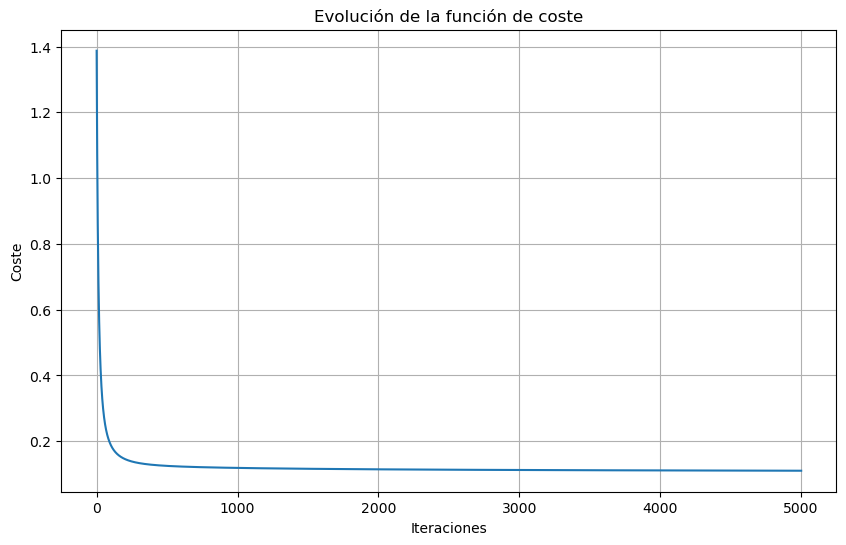

In [8]:
# Hiperparámetros
learning_rate = 0.1
num_iterations = 5_000

# Ejecutar el descenso del gradiente multinomial
W_optimal, cost_history = gradient_descent_multinomial(X, y, learning_rate, num_iterations)

# Imprimir coste inicial y final
print(f"Coste inicial: {cost_history[0]}")
print(f"Coste final: {cost_history[-1]}")

# Hacer predicciones
probabilities = predict(X, W_optimal)

# Obtener la clase predicha
predicted_houses = np.argmax(probabilities, axis=1)
actual_houses = np.argmax(y, axis=1)
accuracy = np.mean(predicted_houses == actual_houses)
print(f"\nPrecisión del modelo: {accuracy:.4f}")

# Visualizar la evolución del coste
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title('Evolución de la función de coste')
plt.xlabel('Iteraciones')
plt.ylabel('Coste')
plt.grid(True)
plt.show()

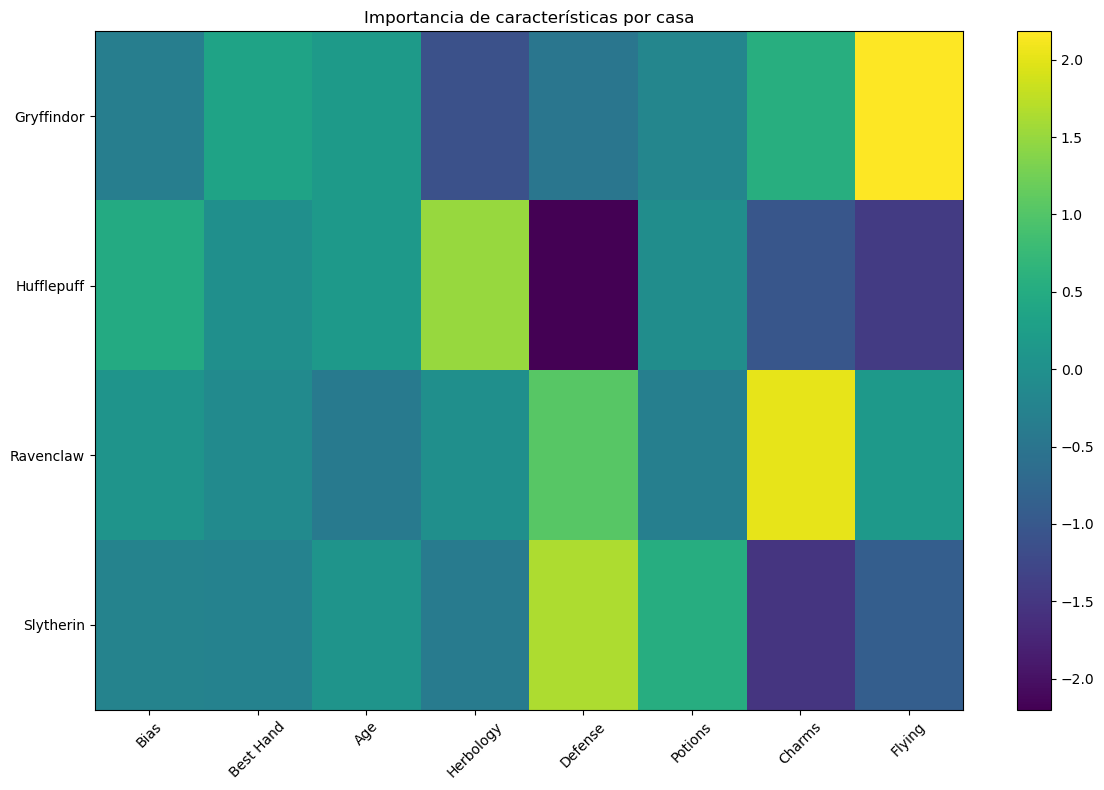

In [9]:
# Visualizar pesos para cada característica
feature_names = ['Bias', 'Best Hand', 'Age', 'Herbology', 'Defense', 'Potions', 'Charms', 'Flying']
house_names = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']

plt.figure(figsize=(12, 8))
plt.imshow(W_optimal.T, aspect='auto')
plt.colorbar()
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.yticks(range(len(house_names)), house_names)
plt.title('Importancia de características por casa')
plt.tight_layout()
plt.show()

## Grabación de los pesos óptimos

In [10]:
def save_weights(W, output_file='../output/model_weights.json'):
    """
    Guarda los pesos del modelo en formato JSON
    
    Parámetros:
    W: matriz de pesos numpy del modelo
    output_dir: directorio donde guardar el archivo
    """
    import json
    
    # Convertir matriz de pesos numpy a lista
    weights = W.tolist()
    
    # Guardar en JSON
    with open(output_file, 'w') as f:
        json.dump(weights, f)


# Después del entrenamiento
save_weights(W_optimal)

## Preparar los datos de test
Preparar X_test seleccionando solo las columnas usadas en entrenamiento y añadiendo el término de sesgo.

Necesitaremos preparar los datos en el formato correcto para hacer las predicciones:

In [11]:
# Ahora solo necesitamos el Dataset de test
df_test = pd.read_csv('../datasets/normal_test.csv')

In [12]:
# Preparar X_test (agregar columna de 1's para el término de sesgo)
X_test = df_test[['Best Hand', 'Age', 'Herbology', 'Defense Against the Dark Arts',
                  'Potions', 'Charms', 'Flying']]
X_test = np.c_[np.ones(len(X_test)), X_test]
X_test = np.array(X_test)

print("\nForma de X_test:", X_test.shape)


Forma de X_test: (400, 8)


## Predicciones con los datos de test
Ahora podemos usar la función predict que ya teníamos y los pesos óptimos (W_optimal) para hacer las predicciones.

In [13]:
# Hacer predicciones usando los pesos óptimos del entrenamiento
probabilities = predict(X_test, W_optimal)

# Obtener la clase predicha (la casa con mayor probabilidad)
predicted_houses = np.argmax(probabilities, axis=1)

# Convertir los índices a nombres de casas
house_names = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']
predictions = [house_names[idx] for idx in predicted_houses]

# Mostrar algunas predicciones
print("\nPrimeras 5 predicciones:")
for i in range(5):
    print(f"Estudiante {i+1}:")
    print(f"Casa predicha: {predictions[i]}")
    print(f"Probabilidades: Gryffindor: {probabilities[i][0]:.3f}, Hufflepuff: {probabilities[i][1]:.3f}, "
          f"Ravenclaw: {probabilities[i][2]:.3f}, Slytherin: {probabilities[i][3]:.3f}\n")


Primeras 5 predicciones:
Estudiante 1:
Casa predicha: Hufflepuff
Probabilidades: Gryffindor: 0.007, Hufflepuff: 0.985, Ravenclaw: 0.007, Slytherin: 0.001

Estudiante 2:
Casa predicha: Ravenclaw
Probabilidades: Gryffindor: 0.012, Hufflepuff: 0.013, Ravenclaw: 0.938, Slytherin: 0.037

Estudiante 3:
Casa predicha: Gryffindor
Probabilidades: Gryffindor: 0.997, Hufflepuff: 0.001, Ravenclaw: 0.001, Slytherin: 0.002

Estudiante 4:
Casa predicha: Hufflepuff
Probabilidades: Gryffindor: 0.007, Hufflepuff: 0.966, Ravenclaw: 0.022, Slytherin: 0.005

Estudiante 5:
Casa predicha: Hufflepuff
Probabilidades: Gryffindor: 0.025, Hufflepuff: 0.931, Ravenclaw: 0.033, Slytherin: 0.010



In [14]:
# 5. Crear y guardar el archivo houses.csv
predictions_df = pd.DataFrame({
    'Index': range(len(predictions)),
    'Hogwarts House': predictions
})
predictions_df.to_csv('../output/houses.csv', index=False)

# 6. Verificar algunas predicciones
print("\nPrimeras 6 predicciones:")
print(predictions_df.head(6))

# 7. Verificar el formato del archivo creado
print("\nContenido del archivo houses.csv (primeras 7 líneas):")
with open('houses.csv', 'r') as file:
    for i, line in enumerate(file):
        if i < 7:
            print(line.strip())  # strip() elimina los saltos de línea extra


Primeras 6 predicciones:
   Index Hogwarts House
0      0     Hufflepuff
1      1      Ravenclaw
2      2     Gryffindor
3      3     Hufflepuff
4      4     Hufflepuff
5      5      Slytherin

Contenido del archivo houses.csv (primeras 7 líneas):
Index,Hogwarts House
0,Hufflepuff
1,Ravenclaw
2,Gryffindor
3,Hufflepuff
4,Hufflepuff
5,Slytherin
